## Load synthetic InSAR Data and compare to Observations
To be run in environment `seissol`

This notebook is an adaptation of Mathilde's adaptation (`compare_geodqeticMM_mathilde-original.py`) of Thomas's code. 

## Define Functions

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import os
import rasterio
import seissolxdmf
import time
from scipy import spatial
from multiprocessing import Pool, cpu_count, Manager
from pyproj import Transformer
from cmcrameri import cm
import matplotlib
from rasterio.plot import show
import scipy.interpolate as interp
import xarray as xr
import pygmt
import re

def nanrms(x, axis=None):
    return np.sqrt(np.nanmean(x**2, axis=axis))

def setup_map(ax,extentmap,gridlines_left=True, draw_labels=True):
    """Setup the background map with cartopy"""
    ax.set_extent(extentmap, crs=ccrs.PlateCarree())
    scale = "10m"
    ax.add_feature(cfeature.LAND.with_scale(scale), facecolor='whitesmoke', rasterized=True)
    ax.add_feature(cfeature.OCEAN.with_scale(scale), rasterized=True)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale))
    ax.add_feature(cfeature.BORDERS.with_scale(scale), linestyle=":")
    locs = np.arange(-180, 180, 1.0)
    gl = ax.gridlines(draw_labels=draw_labels, ylocs=locs, xlocs=locs)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = gridlines_left
    for fn in [
        "/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/fault-geometry/combined-drm-geometry_v05/combined-drm-geometry_v05.shp" # shape file with fault traces, each as a line object
    ]:
        sf = shp.Reader(fn)
        for sr in sf.shapeRecords():    # for each fualt?
            listx = []
            listy = []
            for xNew, yNew in sr.shape.points:
                listx.append(xNew)
                listy.append(yNew)
            ax.plot(listx, listy, "k", linewidth=0.5)

def read_observation_data_one_band(fn):
    with rasterio.open(fn) as src:
        ew = src.read(1)
        print("band 1 has shape", ew.shape)
        ds = downsampling
        height, width = ew.shape
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        lon_g, lat_g = rasterio.transform.xy(src.transform, rows, cols)
        lon_g = np.array(lon_g)[::ds, ::ds]
        lat_g = np.array(lat_g)[::ds, ::ds]
        ew = ew[::ds, ::ds]
        return lon_g, lat_g, ew


def compute_LOS_displacement_SeisSol_data(
    lon_g, lat_g, theta_g, phi_g, lonlat_barycenter, U, V, W
):

    if band == "azimuth":
        D_los = U * np.sin(phi_g) + V * np.cos(phi_g)
    else:
        D_los = W * np.cos(theta_g) + np.sin(theta_g) * (
            U * -np.cos(phi_g) + V * np.sin(phi_g)
        )
        # D_los = W * np.sin(theta_inter) + np.cos(theta_inter) * (U * np.cos(phi_inter) + V * np.sin(phi_inter))
    return -D_los

def compute_LOS_displacement_SeisSol_data2(lon_g, lat_g, vx, vy, vz, lonlat_barycenter, U,V,W):
    D_los = U * vx + V * vy + W * vz
    return -D_los
    
    
def read_seissol_surface_data(xdmfFilename):
    """
    Read unstructured free surface output and associated data.
    compute cell_barycenter
    
    
    Parameters
    ----------
    xdmfFilename : string
        Full path to the .xdmf file

    Returns
    -------
    lons, lats, lonlat_barycenter, connect, U, V, W
    lons, lats: n x 1 array the locations of each grid point where surface deformation is defined in the model. 
        I believe this is in WGS84 but need to check
        Where n is the number of points in the surface mesh
        i.e. for Haiti low res mesh this is (16347,)
    lonlat_barycenter: n x 2 array where each column is the lon and lat coords of the barycenter of a triangle
        Where n is the number of triangles (need to check this!)
        i.e. for Haiti low res mesh this is (32526, 2)
    connect: n x 3 array, where the columns contain indices for the corners of each triangle at the surface
    U, V, W: each are an nd-array where each is a component of modeled surface deformation:
        U = u1
        V = u2
        W = u3
    """
    sx = seissolxdmf.seissolxdmf(xdmfFilename)

    xyz = sx.ReadGeometry()
    connect = sx.ReadConnect()
    U = sx.ReadData("u1", sx.ndt - 1)
    V = sx.ReadData("u2", sx.ndt - 1)
    W = sx.ReadData("u3", sx.ndt - 1)
    # project the data to geocentric (lat, lon)

    # myproj = "+proj=tmerc +datum=WGS84 +k=0.9996 +lon_0=37.0 +lat_0=37.0"
    # UTM =  'epgs:32618'
    # WGS84 = "epsg:4326"
    transformer = Transformer.from_crs("epsg:32618", "epsg:4326", always_xy=True)
    lons, lats = transformer.transform(xyz[:, 0], xyz[:, 1])    # 
    xy = np.vstack((lons, lats)).T  # gives a grid of lon,lat values, need to check the format

    # compute triangule barycenter
    lonlat_barycenter = (
        xy[connect[:, 0], :] + xy[connect[:, 1], :] + xy[connect[:, 2], :]
    ) / 3.0

    return lons, lats, lonlat_barycenter, connect, U, V, W

def interpolate_seissol_surf_output(lonlat_barycenter, U, V , W, df):
    """interpolate SeisSol free surface output to GPS data location"""

    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, U)
    locGPS = np.vstack((df["lon"].to_numpy(), df["lat"].to_numpy())).T

    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, U)
    ui = Fvsm.__call__(locGPS)
    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, V)
    vi = Fvsm.__call__(locGPS)
    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, W)
    wi = Fvsm.__call__(locGPS)

    return ui, vi, wi


def extract_jobid(string):
    # Use regular expression to find the pattern 'jobid_<digits>'
    """Input: string that contains 'jobid_XXXXXX'"""
    match = re.search(r'jobid_(\d+)', string)
    if match:
        return match.group(1)  # Extract the number
    else:
        return None  # Return None if the pattern is not found

## Read in InSAR Observation data
And define a set of observation points that we will want to use later

In [71]:
## Read in InSAR observation data from a CSV
# Write to geodataframe, with lon / lat fields as geometry
# Set geometry reference frame as WGS84

# Define SeisSol surface XDMF file
obsFile = '/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/observation-data/insar/data/csv/A2_A042_20210101-20210827_los.csv'
# Extract the directory path and filename
obsPath, filename = os.path.split(obsFile)
# Ex1tract the filebase by removing the extension
obsFilebase, _ = os.path.splitext(filename)

# Output the results
print(f"CSV path: {obsPath}")
print(f"CSV filebase: {obsFilebase}")

# Read in CSV file to dataframe
obs_df = pd.read_csv(obsPath+ '/' + obsFilebase+'.csv')

## Write to a geopandas dataframe, skip this for now. 
# gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.lon, df.lat, df.elevation, crs="EPSG:4326"), data=df)

# Create an array with observations location lat/lons for later use. 
lon_obs, lat_obs = obs_df.lon.array, obs_df.lat.array
locData = np.vstack((lon_obs,lat_obs)).T

# Convert observation data to an xarray DataSet
obs_ds = xr.Dataset.from_dataframe(obs_df.set_index(['lat', 'lon']))
# Convert "los_mm" from millimeters to meters
obs_ds['los_mm'] = obs_ds['los_mm'] / 1000
# Rrename the variable to reflect the new unit
obs_ds = obs_ds.rename({'los_mm': 'los_m'})

## Save as .nc file for later use if needed. 
# obs_ds.to_netcdf(datadir + filebase + '.nc')


CSV path: /Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/observation-data/insar/data/csv
CSV filebase: A2_A042_20210101-20210827_los


## Read in Synthetic Data

In [128]:
# Define SeisSol surface XDMF file
xdmfFilename = '/Users/hyin/ags_local/data/haiti_seissol_data/FL33_dynamic-relaxation/jobid_3437317/FL33_jobid_3437317_output_extracted-surface.xdmf'
# Extract the directory path and filename
xdmfPath, filename = os.path.split(xdmfFilename)
# Extract the filebase by removing the extension
xdmfFilebase, _ = os.path.splitext(filename)
jobid = extract_jobid(xdmfFilebase)

# Output the results
print(f"XDMF path: {xdmfPath}")
print(f"XDMF filebase: {xdmfFilebase}")
print(f"JobID: {jobid}")

# Read Modeled surface deformation data from surface xdmf
vertex_lon, vertex_lat, lonlat_barycenter, connect, U, V, W=read_seissol_surface_data(xdmfFilename)
lonlat_barycenter[:, 0] = lonlat_barycenter[:, 0] + 360
# There are 32526 triangles and 16347 vertices
# latlon_barycenter is a (32526,2) array, with lat and lon for every triangle
# U, V, W are (32526,) arrays
# vertex_lon and vertex_lat are (16347,) arrays

# ## Interpolate modeled data at each observed point
# Where df is the dataframe with InSAR observation points
x_synth_i, y_synth_i, z_synth_i = interpolate_seissol_surf_output(lonlat_barycenter, U, V , W, obs_df)

# Convert arrays to a pandas dataframe
synth_df = pd.DataFrame({
    'lat': obs_df['lat'],
    'lon': obs_df['lon'],
    'x_synth_i': x_synth_i.flatten(),
    'y_synth_i': y_synth_i.flatten(),
    'z_synth_i': z_synth_i.flatten()
})

# Convert df to xarray DataSet
synth_ds = xr.Dataset.from_dataframe(synth_df.set_index(['lat', 'lon']))


XDMF path: /Users/hyin/ags_local/data/haiti_seissol_data/FL33_dynamic-relaxation/jobid_3437317
XDMF filebase: FL33_jobid_3437317_output_extracted-surface
JobID: 3437317


In [137]:
## Merge into megadataset 
merged_ds = obs_ds.assign(x_synth_i=synth_ds['x_synth_i'],y_synth_i=synth_ds['y_synth_i'], z_synth_i=synth_ds['z_synth_i'])
merged_ds['look_U'].mean()

## Calculate synthetic LOS vectors & Residuals
# Element-by-element addition
merged_ds['los_synth_m'] = merged_ds['x_synth_i']*merged_ds['look_E'] + merged_ds['y_synth_i']*merged_ds['look_N'] + merged_ds['z_synth_i']*merged_ds['look_U']
merged_ds['los_diff'] = merged_ds['los_m'] - merged_ds['los_synth_m']
rms =nanrms(merged_ds['los_diff'])
rms = str(round(rms, 3))

## Plot the Results
Working, tested single panel plot in the cell below

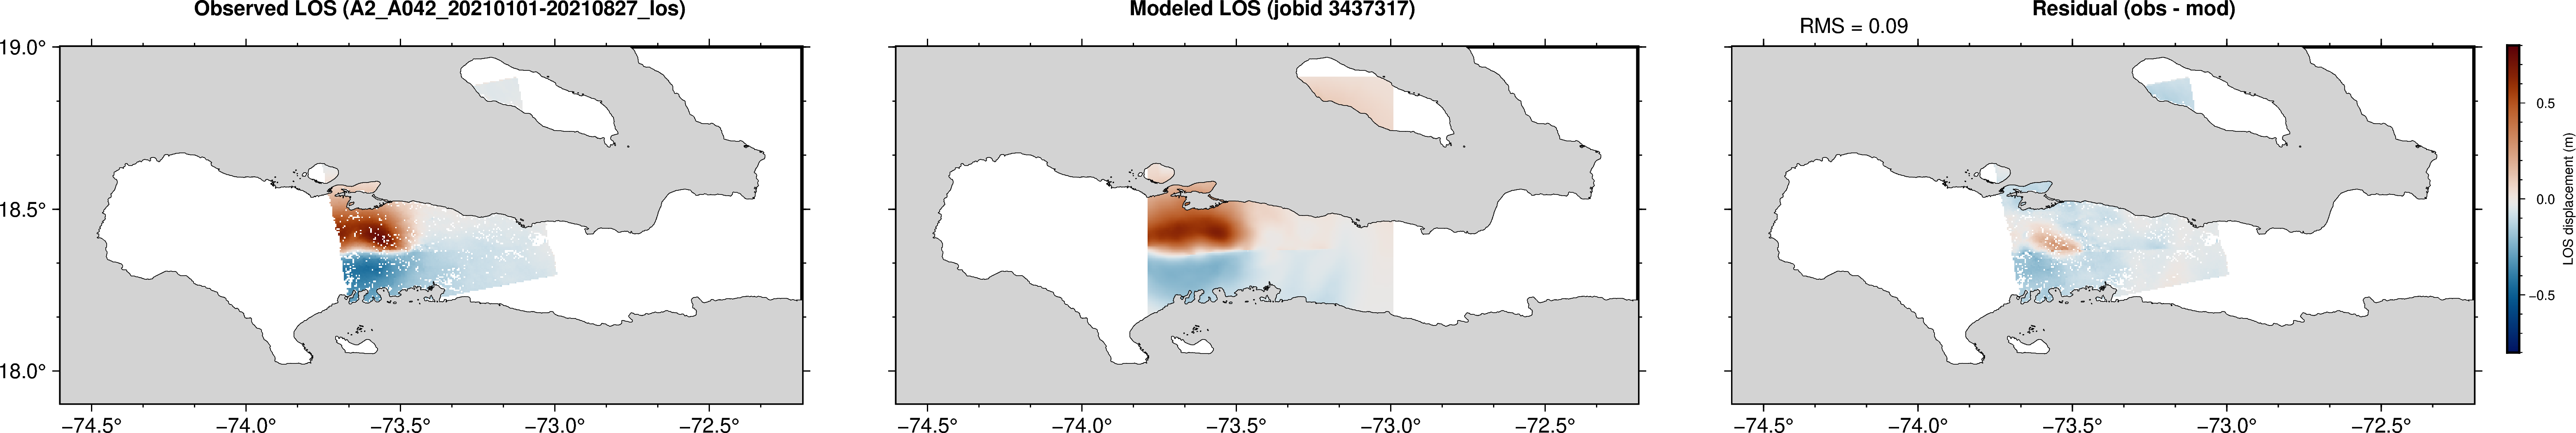

In [147]:
# Set up the PyGMT figure with two panels
import pygmt
fig = pygmt.Figure()

pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT="12p")
projection = 'M6i'
# fig.coast(shorelines=False, region=rgn, projection=projection, land="lightgrey")
rgn = [-74.6, -72.2, 17.9, 19]
watercolor = 'lightgray'


# Create a color palette
pygmt.makecpt(cmap="vik", series=[-0.8, 0.8])

# Define the layout for a 1-row, 3-column subplot
with fig.subplot(nrows=1, ncols=3, figsize=("20i", "8.5i"), sharex="b", sharey="l", frame=["a", "WSne"]):
    
    # Left Panel: Observed LOS data
    with fig.set_panel(panel=0):
        fig.basemap(region=rgn, projection=projection, frame=True)
        fig.grdimage(region=rgn, grid=merged_ds['los_m'], projection=projection, cmap=True)
        fig.coast(region=rgn, projection=projection, shorelines=True, water=watercolor)
        fig.text(x=rgn[0] + 0.4, y=rgn[3] - 0.9, text="Observed LOS (" + obsFilebase + ")", font="12p,Helvetica-Bold", justify="TL")

    # Middle Panel: Synthetic LOS data
    with fig.set_panel(panel=1):
        fig.grdimage(region=rgn, grid=merged_ds['los_synth_m'], projection=projection, frame="af", cmap=True)
        fig.coast(region=rgn, projection=projection, shorelines=True, water=watercolor)
        fig.text(x=rgn[0] + 0.7, y=rgn[3] - 0.9, text="Modeled LOS (jobid " + jobid + ")", font="12p,Helvetica-Bold", justify="TL")

    # Right Panel: Residual (los_m - los_synth_m)
    with fig.set_panel(panel=2):
        fig.grdimage(region=rgn, grid=merged_ds['los_diff'], projection=projection, frame="af", cmap=True)
        fig.coast(region=rgn, projection=projection, shorelines=True, water=watercolor)
        fig.colorbar(frame='af+lLOS displacement (m)',position="JBR+o-0.5c/-0.5c")
        fig.text(x=rgn[0] + 0.9, y=rgn[3]  - 0.9, text="Residual (obs - mod)", font="12p,Helvetica-Bold", justify="TL")
        fig.text(x=rgn[0] + 0.2, y=rgn[3]  - 0.95, text="RMS = " + str(rms), font="12p,Helvetica", justify="TL", fill="white")

fig.show()
fig.savefig(xdmfPath+'/los-comparison_'+obsFilebase+'_jobid_'+jobid+'.jpg')
